<a href="https://colab.research.google.com/github/AilingLiu/analysis_on_study_app/blob/master/Mobile_app_user_analysis_ABTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Analyze user logging sessions with AB testing on new feature, to understand if the new feature is statistically significant, and present suggestions/conclusions to product owner.

# Set up

In [0]:
import sys
assert(sys.version_info >=(3, 5))

import sklearn
assert(sklearn.__version__ >= "0.20")

import numpy as np
import os

import pandas as pd
pd.set_option('display.max_rows', 100)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# create project directory
PROJECT_ROOT_DIRECTORY = '.'
PROJECT_ID = 'Language_learning_app'
IMAGE_DIR = os.path.join(PROJECT_ROOT_DIRECTORY, PROJECT_ID, 'IMAGES')
os.makedirs(IMAGE_DIR, exist_ok=True)
DATA_DIR = os.path.join(PROJECT_ROOT_DIRECTORY, PROJECT_ID, 'DATA')
os.makedirs(DATA_DIR, exist_ok=True)

# save figure
def save_fig(name, path=IMAGE_DIR, extension='png', resolution=300, tight_layout=True):
  fig_path = os.path.join(path, name + '.' + extension)
  if tight_layout:
    plt.tight_layout()
  print('Saving figure ', name)
  plt.savefig(fig_path, format=extension, dpi=resolution)

# ignore warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Get data

In [0]:
data_url = 'https://github.com/AilingLiu/analysis_on_study_app/blob/master/data.zip?raw=true'

import urllib
import shutil
from zipfile import ZipFile

def fetch_data(data_url=data_url, data_dir=DATA_DIR):
  if not os.path.isdir(DATA_DIR):
    os.makedirs(DATA_DIR)
  data_path = os.path.join(data_dir, 'mobile_app_data.zip')
  urllib.request.urlretrieve(data_url, data_path)
  with ZipFile(data_path) as zip_file:
    for member in zip_file.namelist():
        filename = os.path.basename(member)
        if not filename:
            continue
        # copy file (taken from zipfile's extract)
        source = zip_file.open(member)
        target = open(os.path.join(data_dir, filename), "wb")
        with source, target:
            shutil.copyfileobj(source, target)
    print('Done!') 

fetch_data()

Done!


In [0]:
# check first few lines of document
!head -5 './Language_learning_app/DATA/learner_item_data.csv'

uuid,created_at,trainer_item_id
6953977,2017-01-16 10:54:43.386,0
6953977,2017-01-16 10:56:25.717,1
6953977,2017-01-16 10:55:50.642,2
6953977,2017-01-16 10:54:19.796,3


# Load Data

In [0]:
import pandas as pd

learner_data = 'learner_item_data.csv'

def load_mobile_data(data_path=DATA_DIR, file_name=learner_data):
    csv_path = os.path.join(data_path, file_name)
    return pd.read_csv(csv_path, dtype={'uuid': object,'trainer_item_id': object}, parse_dates=True)

In [0]:
learner_item = load_mobile_data()
learner_item.head()

,uuid,created_at,trainer_item_id
0,6953977,2017-01-16 10:54:43.386,0
1,6953977,2017-01-16 10:56:25.717,1
2,6953977,2017-01-16 10:55:50.642,2
3,6953977,2017-01-16 10:54:19.796,3
4,6953977,2017-01-16 10:55:10.654,1


# Explore Dataset

In [0]:
learner_item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1144310 entries, 0 to 1144309
Data columns (total 3 columns):
uuid               1144310 non-null object
created_at         1144310 non-null object
trainer_item_id    1144310 non-null object
dtypes: object(3)
memory usage: 26.2+ MB


In [0]:
# change the data type of 'created_at' as datetime
learner_item['created_at'] = pd.to_datetime(learner_item['created_at'], utc=True)

In [0]:
learner_item.uuid.nunique() # number of unique users in this dataset

7355

In [0]:
learner_item.shape

(1144310, 3)

In [0]:
print('Earlier data created at: {}'.format(learner_item.created_at.min()))
print('Latest data created at: {}'.format(learner_item.created_at.max()))
print('Range of time: {}'.format(learner_item.created_at.max() - learner_item.created_at.min()))

Earlier data created at: 2016-12-02 09:42:32.694000+00:00
Latest data created at: 2017-02-02 00:01:48.316000+00:00
Range of time: 61 days 14:19:15.622000


**shape of dataset**

This dataset has 1,144,310 rows, 3 columns. Not a large dataset, to split dev and validation set, we can consider using .3 as validation set ratio.

**data types**

It has 2 categorical attributes (in pandas it's registered as object) and 1 datatime object.

There are no missing values in this dataset

**Range of Time**

This dataset covers two months of records.

# sessionization of activities

The events are not grouped into sessions, so first thing first is to identify those. We define a session as a sequence of events with the same user ID, ordered by timestamp, such that the time difference between any consecutive pair of events is at most one hour.

In [0]:
# sort data by user id and session time (created time)
learner_item = learner_item.sort_values(by=['uuid', 'created_at'])

In [0]:
from datetime import timedelta

# set threshold T as maximum session length
T = timedelta(seconds=60*60)

def create_1hr_session(df, max_duration=T):
  dfm = df.copy()
  dfm['new_session'] = (dfm[['created_at']].diff()>=max_duration).astype(int)
  dfm['increment'] = dfm.groupby('uuid')['new_session'].cumsum()
  dfm['session_id'] = dfm['uuid'].astype(str) + '_' + dfm['increment'].astype(str)
  dfm.sort_values(by=['uuid','created_at'], inplace=True)
  dfm.drop(columns=['new_session', 'increment'], axis=1, inplace=True)
  return dfm

user_sessions = create_1hr_session(learner_item)
user_sessions.head()

,uuid,created_at,trainer_item_id,session_id
971898,1002313,2017-01-30 13:23:15.582000+00:00,6756,1002313_0
971891,1002313,2017-01-30 13:25:27.201000+00:00,6754,1002313_0
971892,1002313,2017-01-30 13:25:49.940000+00:00,6755,1002313_0
971896,1002313,2017-01-30 13:26:35.301000+00:00,6753,1002313_0
971893,1002313,2017-01-30 13:27:19.056000+00:00,6755,1002313_0


# Analysis on sessions

## What is the distribution (histogram) of session lengths?

In [0]:
# extract session duration in mins
session_gb_duration = user_sessions.groupby('session_id').apply(lambda gb: np.round((gb.iloc[-1, 1]-gb.iloc[0, 1])/timedelta(minutes=1), 2))
session_gb_duration[:10]

session_id
1002313_0     5.26
1003270_0     3.80
1003726_0     1.63
1003726_1    16.51
1003726_2    24.86
1003911_0    18.54
1003911_1     7.01
1003911_2     0.07
1005340_0    14.43
1006034_1     1.26
dtype: float64

Saving figure  EDA_Session_Duration_Hist


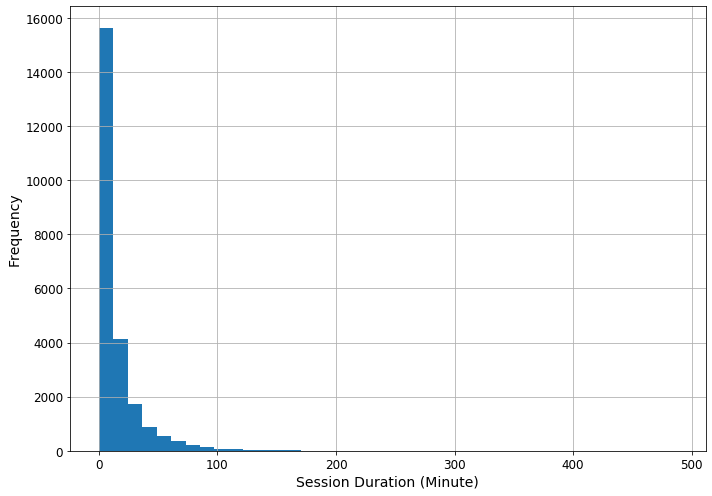

In [0]:
# plot session duration in histogram
session_gb_duration.hist(bins=40, figsize=(10, 7))
plt.xlabel('Session Duration (Minute)')
plt.ylabel('Frequency')
save_fig('EDA_Session_Duration_Hist')

In [0]:
session_gb_duration.describe()

count    23931.000000
mean        14.550179
std         21.395549
min          0.000000
25%          2.600000
50%          6.970000
75%         17.350000
max        487.430000
dtype: float64

There are 23,931 sessions in total in this dataset. 25% of the instances have a session length lower than 2.6 minutes, 50% are lower than 6.97, and 75% lower than 17.35. The standard deviation at 21.40 shows how dispersed the values are.

The histogram shows the session length is tail-heavy: they extend much further to the right of median than to the left. This may be hard for machine learning algorithms as it expect to have bell shape. We can transform it before fitting models.

## How many people do several sessions a day? How many sessions?

In [0]:
# extract number of sessions per day per user
sessions_per_day = user_sessions.groupby([user_sessions.uuid, user_sessions.created_at.dt.to_period('D')])['session_id'].nunique().to_frame('session_per_day')

# extract maximum sessions per day per user
max_sessions_per_day = sessions_per_day.max(level=0)

print('\nNumber of people do several sessions per day: {}'.format((max_sessions_per_day>1).sum()[0]))

/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,



Number of people do several sessions per day: 863


In [0]:
# average sessions per day per user
avg_sessions_per_day = sessions_per_day.mean(level=0)
avg_sessions_per_day.describe()

,session_per_day
count,7355.000000
mean,1.042616
std,0.158773
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,3.444444


Saving figure  EDA_Avg_Sessions_Per_Day_Hist


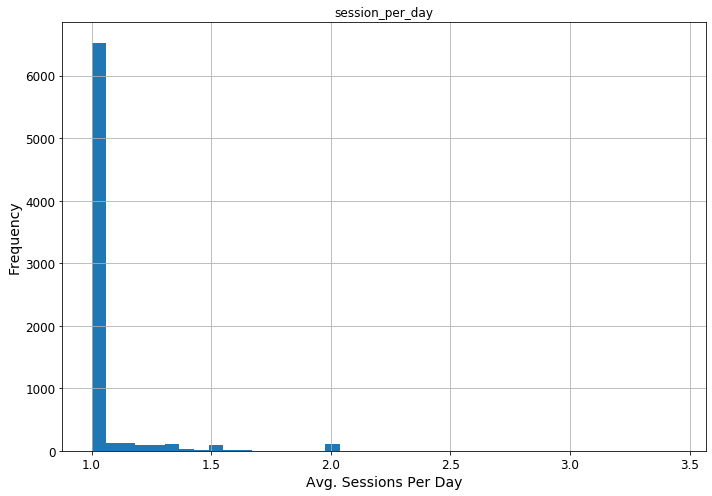

In [0]:
avg_sessions_per_day.hist(bins=40, figsize=(10, 7))
plt.xlabel('Avg. Sessions Per Day')
plt.ylabel('Frequency')
save_fig('EDA_Avg_Sessions_Per_Day_Hist')

In [0]:
# multiple sessions per day per user
multiple_session_mask = sessions_per_day['session_per_day'] > 1
multiple_sessons_per_day = sessions_per_day.loc[multiple_session_mask]

In [0]:
multiple_sessons_per_day.describe()

,session_per_day
count,1486.000000
mean,2.166891
std,0.491415
min,2.000000
25%,2.000000
50%,2.000000
75%,2.000000
max,5.000000


There are 7355 users in this dataset. 50% of the users have 1 session per day. The standard deviation is 0.16, indicating majority of the users mainly conduct 1 sesson daily. Nevertheless, as the histogram is skewed to the right, there are 25% of users are having at least 2 sessions per day.

Among these 25% users, we get the exact multi-session user number: 863, i.e. users that perform several sessions in any of the day. 75% sessions under 2, maximum sessions 5 session in any of the day.

# A/B Test on new feature

Assume the app owner built a new feature that is supposed to increase activity. To test if it actually increases activity it got released as an A/B test with 40% of the users seeing the new feature (test group) and 60% not seeing it (control group). Possible two metrics to measure the activity:

*  Proportion of users per experiment group who do more than one session on at
least one day
*  Median time per session

Check if the new feature has impact on above two metrics. If yes, check how big is the impact.




# Load Test Group Data

In [0]:
# check first few lines of document
!head -5 './Language_learning_app/DATA/test_groups.csv'

test_group,uuid
control,6953977
test,1607983
control,6658627
control,4848596


In [0]:
experiment_data = 'test_groups.csv'

def load_exp_data(data_path=DATA_DIR, file_name=experiment_data):
    csv_path = os.path.join(data_path, file_name)
    return pd.read_csv(csv_path, dtype={'test_group': object,'uuid': object})

In [0]:
exp_data = load_exp_data()
exp_data.head()

,test_group,uuid
0,control,6953977
1,test,1607983
2,control,6658627
3,control,4848596
4,test,1653336


## Metric 1: Proportion of users per experiment group who do more than one session on at least one day

In [0]:
multiple_session_status = (max_sessions_per_day>1).rename(columns={'session_per_day': 'multiple_session_conducted'}).reset_index()
exp_in_dict = exp_data.set_index('uuid').to_dict('dict')['test_group']

multiple_session_status['test_group']=multiple_session_status['uuid'].map(exp_in_dict)
multiple_session_status.head(5)

,uuid,multiple_session_conducted,test_group
0,1002313,False,test
1,1003270,False,control
2,1003726,True,control
3,1003911,False,test
4,1005340,False,test


Method: 

We will first create count table where users are grouped based on whether they met metric (If yes: True; Else: Fale). 

Then we will conduct chi square test to test the independence of new feature and its effect on user sessions. If the null hypothesis is rejected, it means these two categorical features are related, hence the metric is proved. We will then use phi coefficient to evaluate its strenght of correlation. 

Otherwise, if we fail to reject null hypothesis, we will use z test to compare two proportions and again check if these two proportions are different.

In [0]:
def create_count_table(df, group_col='test_group', event_col='multiple_session_conducted', success_label=True):
  count_tab = pd.crosstab(df[group_col], df[event_col], margins=True, margins_name='Total')
  prop_tab=pd.crosstab(df[group_col], df[event_col], margins=True, margins_name='Total', normalize='index').round(4)
  full_tab = count_tab.join(prop_tab, lsuffix='_count', rsuffix='_prop')
  print('Count Table: ')
  print('*'*40)
  display(full_tab)
  return full_tab

full_tab = create_count_table(multiple_session_status)
contingency =full_tab.iloc[:2, :2]

Count Table: 
****************************************


multiple_session_conducted,False_count,True_count,Total,False_prop,True_prop
test_group,,,,,
control,3815,494,4309,0.8854,0.1146
test,2677,369,3046,0.8789,0.1211
Total,6492,863,7355,0.8827,0.1173


From the count table above, it shows test group has 1% more than control group on the metric subject. We can construct null hypothesis and use [Chi-square test](https://en.wikipedia.org/wiki/Chi-squared_test#Example_chi-squared_test_for_categorical_data) to check their relationship:

**Null Hypothesis**: $u_1=u_2$, i.e. the metric1(proportion of 2+ sessions) is independent on new feature 

In [0]:
from scipy.stats import chi2_contingency

c, p, dof, expected = chi2_contingency(contingency)
print('test statistic: {:.2f}\n p value: {:.2f}\n degree of freedom: {} \nexpected frequencies: \n{}\n'.format(c, p, dof, expected.round(3)))

alpha = 0.05
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

test statistic: 0.67
 p value: 0.41
 degree of freedom: 1 
expected frequencies: 
[[3803.403  505.597]
 [2688.597  357.403]]

Independent (fail to reject H0)


We can conclude that the new feature fails statistical significance test. We will continue to proceed z test to compare the proportions of multiple sessions in control and test group.

In [0]:
# compare proportions of success between control and experiment group based on binomial distribution
def get_event_counts(count_table, control_name='control', exp_name='test', success_label='True_count'):
  x_cont, x_exp = count_table.loc[control_name, success_label], count_table.loc[exp_name, success_label]
  N_cont, N_exp = count_table.loc[control_name, 'Total'], count_table.loc[exp_name, 'Total']
  return x_cont, x_exp, N_cont, N_exp  

def get_ab_proportion(x_cont, x_exp, N_cont, N_exp):
  con_prop = round(x_cont/N_cont, 3)
  exp_prop = round(x_exp/N_exp, 3)
  print('Estimated proportion in Experiment Group: {}\nEstimated proportion in Control Group: {}'.format(exp_prop, con_prop))
  return exp_prop, con_prop 

def get_prop_diff(exp_prop, cont_bprop):
  estimated_diff = round(exp_prop - cont_bprop, 5)
  print('The change due to the experiment is: {}%'.format(estimated_diff*100))
  return estimated_diff

def get_poopled_prob(x_cont, x_exp, N_cont, N_exp):
  return round((x_cont + x_exp) / (N_cont + N_exp), 5)

def get_pooled_stderr(pool_prob, n_cont, n_exp):
  pool_stderr = np.round(np.sqrt(pool_prob*(1-pool_prob)*(1/n_cont + 1/n_exp)), 5)
  print('Pooled Standard Error(Uncertainty): {}'.format(pool_stderr))
  return pool_stderr

def calculate_margin_error(sig_level=0.05, stderr=0.005):
  import scipy.stats as st
  me = round(st.norm.ppf(1-sig_level/2)*stderr, 5)
  print('Calculated Margin Error: {} at {} significance level'.format(me, sig_level))
  return me

def get_confi_interval(cal_mean, margin, sig_level=0.05):
  conf_level = 1-sig_level
  lower_bound = round(cal_mean - margin, 3)
  upper_bound = round(cal_mean + margin, 3)
  print('True value falls into following interval at {}% confidence: [{}, {}]'.format(conf_level*100,lower_bound, upper_bound))
  return lower_bound, upper_bound

def evaluate_result(lower_bound, upper_bound, prac_sig=0.02):
  if upper_bound < 0 or lower_bound > 0:
    print('The change is statistically significant.')
    
    if lower_bound > prac_sig:
      print('The change is practically significant.')
    else:
      print('The change is fail practical significance expectation.')
  else:
    print('Fail to reject null hypothesis. The change is not statistically significant.')

def compare_two_group_proportion(count_table, success_label='True_count', control_name='control', exp_name='test', sig_level=0.05, prac_sig=0.02):

  xcont, xexp, ncont, nexp = get_event_counts(count_table, control_name=control_name, exp_name=exp_name, success_label=success_label)
  ap, bp = get_ab_proportion(xcont, xexp, ncont, nexp)
  d = get_prop_diff(ap, bp)
  p = get_poopled_prob(xcont, xexp, ncont, nexp)
  stdr = get_pooled_stderr(p, ncont, nexp)
  m = calculate_margin_error(sig_level=sig_level, stderr=stdr)
  lb, ub = get_confi_interval(d, m, sig_level=sig_level)
  evaluate_result(lower_bound=lb, upper_bound=ub, prac_sig=prac_sig)

compare_two_group_proportion(full_tab)

Estimated proportion in Experiment Group: 0.121
Estimated proportion in Control Group: 0.115
The change due to the experiment is: 0.6%
Pooled Standard Error(Uncertainty): 0.00762
Calculated Margin Error: 0.01493 at 0.05 significance level
True value falls into following interval at 95.0% confidence: [-0.009, 0.021]
Fail to reject null hypothesis. The change is not statistically significant.


From the z test above, we can conclude the two proportions from control and experiment groups fail to reject null hypothesis, indicating these two group has no difference in the success proportions. 

Although the new feature has a 1% change from the test sample, it is not statistically significant. If we were to implement the new feature on more users, it is not likely to see any improvement on users implementing more than 1 session per day. 


## Metric 2: Median time per session

Method:

We will first use boostrap to resample 1000 times to minimize sample variances of estimation on metric (median time per session).

Then, we will use two sample t test to evaluate the median time per session on the the test and control group. 

In [0]:
#import datetime 
session_time = user_sessions.groupby('session_id')['created_at'].apply(lambda gb: (gb.iloc[-1]-gb.iloc[0])/timedelta(minutes=1)).to_frame('session_in_min')
session_time['uuid'] = session_time.index.str.split('_').str[0]
session_time = session_time.reset_index().merge(exp_data, how='left', on='uuid')

In [0]:
control = session_time.loc[session_time['test_group']=='control', ['session_in_min']]
test = session_time.loc[session_time['test_group']=='test', ['session_in_min']]

Saving figure  EDA_boost_minute_difference


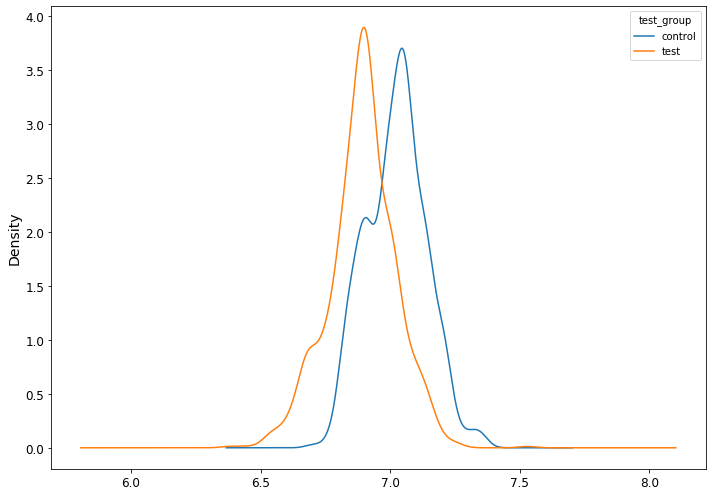

In [0]:
# Creating an list with bootstrapped median for each AB-group
boot_minutes = []
for i in range(1000):
    boot_median = session_time.sample(frac=1, replace=True).groupby('test_group')['session_in_min'].median()
    boot_minutes.append(boot_median)
    
boot_minutes = pd.DataFrame(boot_minutes)
    
# A Kernel Density Estimate plot of the bootstrap distributions
boot_minutes.plot(kind='kde', figsize=(10, 7))
save_fig('EDA_boost_minute_difference')

These two distributions above represent the bootstrap uncertainty over what the underlying session median duration could be for the two AB-groups. Just eyeballing this plot, we can see that there seems to be some evidence of a difference. Specifically, control group has a higher median session duration than test group.

Saving figure  EDA_control_test_diff


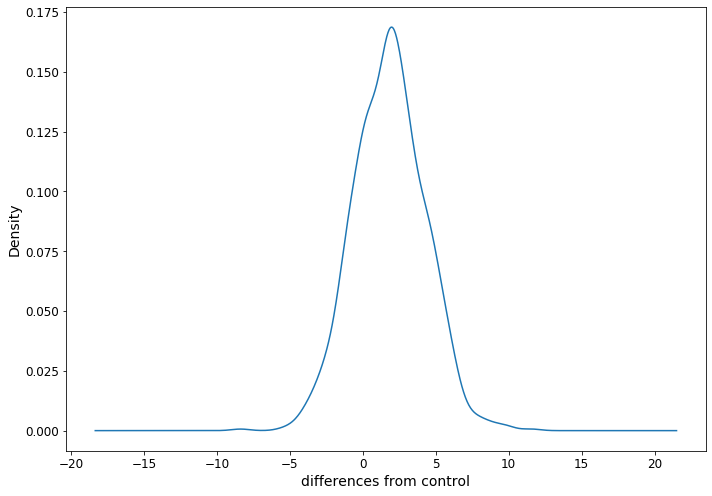

In [0]:
# Adding a column with the % difference between the two AB-groups
boot_minutes['diff'] = (boot_minutes.control - boot_minutes.test)/boot_minutes.control * 100

ax = boot_minutes['diff'].plot(kind='kde', figsize=(10, 7))
ax.set_xlabel('differences from control')
save_fig('EDA_control_test_diff')

From this graph, we can see that the most likely % difference is around 1% - 3%, and that most of the distribution is above 0%, in favor of control group. But what is the probability that the difference is above 0%? Let's calculate that as well.

In [0]:
prob = (boot_minutes['diff']>0).mean()
round(prob*100, 2)

77.7

The bootstrap analysis tells us that there is a high probability (77.7%) that median session duration is better in the control group (no new features). We can now conduct the t test to check if the difference is significant.

In [0]:
control = boot_minutes['control']
test = boot_minutes['test']

#check whether the variane of these two groups are equal
print('variance in control {}'.format(np.var(control)))
print('variance in test {}'.format(np.var(test)))

variance in control 0.013200893430804451
variance in test 0.016510873423741603


In [0]:
from scipy import stats
stats.ttest_ind(control, test, equal_var=False)

Ttest_indResult(statistic=23.82578650821482, pvalue=1.727677086917952e-110)

Pvalue is smaller than significance level 0.05. We will reject null hypothesis and conclude that the two groups have different median session duration. We can continue to measure the effect size using [Cohen's d](https://en.wikipedia.org/wiki/Effect_size).


In [0]:
def calculate_cohens_d(g1, g2):

  differences_group_values = np.subtract(g1, g2)
  std_dev_differences_group_values = np.std(differences_group_values, ddof=1)
  cohens_d = round(abs((g1.mean() - g2.mean())/std_dev_differences_group_values), 2)
  return cohens_d

cohen_d = calculate_cohens_d(control, test)
cohen_d

0.75

There's a 0.75 difference in means in terms of sample standard deviation units. we can claim that new feature has a strong statistical effect on quantity of session duration. If we were to implement the new feature, it is likely that our user will reduce their average session time. Hence, it is not recommended to implement this new feature.